In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap
import mplleaflet

sn.set_context('talk')

In [ ]:
%%javascript
require(['base/js/utils'],
function(utils) {
    utils.load_extensions('calico-spell-check');
});

# ECOREG full analysis (part 1)

If possible, we'd like to get a paper from the ECOREG data, but I'm struggling to make time due to other commitments. The aim of this notebook is to set things out in a more structured way, which will hopefully make it easier to produce a draft manuscript if I get the chance.

## 1. Background and hypotheses

We are interested in better understanding the relationships between in-stream ecology (as represented by various PB and MZB metrics), water chemistry and hydromorphology, especially the degree to which of hydromorphologic alteration does or does not influence ecology. We know that short-term hydrological fluctuations (droughts, floods etc.) have a direct impact on species composition and abundances, but here we are more interested in long-term changes in ecological assemblages driven by modifications to the hydrological regime. The main hypotheses we would like to test are:

 1. Is there a difference in ecology between regulated and unregulated streams? <br><br>
 2. Are there differences in water chemistry and hydromorphology between regulated and unregulated streams? <br><br>
 3. If the answers to (1) and (2) are "yes", can the differences in water chemistry and hydromorphology explain differences in ecology?

In reality, we do not expect to find straightforward answers to these questions. The ecological and water chemistry datasets available in this study represent a single point in time, rather than the long-term average conditions in each stream. It may therefore be difficult or impossible to link these "snap-shots" of water chemistry and ecology to the long-term hydrological regime, especially because we know the ecological assemblages will be most affected by recent hydrological extremes. Furthermore, even dividing our data into simple classes such as "regulated" or "unregulated" is problematic, because our sites exhibit various degrees of regulation from "almost natural" to "heavily modified". With this in mind, it seems likely that some of the "regulated" sites might be indistinguishable from, for example, natural systems downstream of large lakes. Finally, there are significant issues of spatial and temporal scale when it comes to relating catchment scale hydromorphological indices to plot scale ecology and water chemistry metrics: the ecology and water chemistry measurements were all collected in the field at the same time and place, whereas the hydrological indicators (HIs) are estimated by aggregating catchment scale flow records for the preceding several years. For this reason alone, we might expect to find stronger statistical relationships between ecology and water chemistry than between ecology and any of the HIs.

## 2. Literature

I haven't studied anything biological since I was 16. This section summarises some results and ideas from the literature that might be useful.

There are many papers that tackle the question of defining ecologically sustainable flows for regulated river reaches (e.g. [Gorla & Perona, 2013](http://www.sciencedirect.com/science/article/pii/S0022169413001662); [Vogel et al., 2007](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02); [Zhang et al., 2015](http://www.sciencedirect.com/science/article/pii/S0022169415006812)). However, the vast majority of those using catchment scale hydrological data consider the effects on ecology *implicitly*, by assuming that changes in the flow regime can be used as a direct proxy for ecological impact. In other words, they calculate a statistical measure of how much the hydrology has changed, and then assume this is proportional to effects on the ecology. Based on my (admittedly limited) literature search, very few authors have managed to link their hydrological indicators to real ecology data in a convincing way. This must have been attempted (lots of times?) and [Richter et al. (1997)](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-2427.1997.00153.x/abstract) present a good scientific argument as to why we should expect a relationship to exist. However, I've yet to find a clear statistical demonstration of this in the literature without resorting to repeatedly sub-dividing the data, for example by estimating a wide range of different "structure indices" (e.g. [Lorenz et al., 2004](http://link.springer.com/article/10.1023%2FB%3AHYDR.0000025261.79761.b3)), which ultimately seems a bit arbitrary, and in any case would be impossible in our study without gathering more data to define catchment "typologies". 

### 2.1. Indices of hydromorphological change

By far the most widely used metrics for assessing hydromorphological change are the Indicators of Hydrological Alteration (IHA) first proposed by [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract). The authors define 32 metrics in five classes:

 * Magnitude of monthly water conditions
 * Magnitude and duration of annual extreme water conditions
 * Timing of annual extreme water conditions
 * Frequency and duration of high and low pulses
 * Rate and frequency of water condition changes
 
These 32 parameters can either be used to assess hydromorphological change at a single location, by considering changes before and after some intervention (such as building a dam), or they can be used to compare the hydrological regimes between different sites. Most of the studies I have found focusing on hydrological alteration have taken the former approach, using a "before-after" (BA) design, where flow data collected prior to alteration are compared to measurements taken afterwards (e.g. [Richter et al., 1997](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-2427.1997.00153.x/abstract); [Vogel et al., 2007](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract)). In our study, we do not have any data prior to alteration, but we do have an approximate "control-impact" (CI) design for the Norwegian sites: as far as possible, Susi attempted to pair regulated sites with unregulated ones that have otherwise similar characteristics. I'm not sure if this is also the case for the German sites? (It looks unlikely from the map - see below - but **check this**). [Penas et al. (2016)](http://www.sciencedirect.com/science/article/pii/S1470160X15004069) reviewed the statistical power and advantages/disadvantages of different experimental design strategies in the context of assessing hydromorphological alteration. Their (rather obvious) conclusion is that "before-after-control-impact" (BACI) designs are the best, as these provide ways of estimating both spatially and temporally variable confounding factors. In comparison, BA designs are limited because they are not able to detect changes due to natural variability (i.e. the before and after periods are not expected to be the same, regardless of alteration), whereas CI designs are limited because there are no true analogues for the sites (i.e. we assume that a neighbouring unmodified site reflects what the impacted location would have looked like without alteration, which involves some big assumptions regarding site similarity). Note that the approximate CI design of our study therefore places additional constraints on what we can expect to identify statistically.

The IHA metrics are very widely used, but numerous other systems have also been proposed. [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) considered around 170 hydrological metrics applied to more than 400 streams across the USA, demonstrating that the 32 IHA parameters did a reasonable job of representing the overall variability across the wider group of 170. However, they also identified considerable redundancy even within the IHA metrics, suggesting that dimensionality reduction techniques (see below) should be used to define a subset of hydrological parameters for any given analysis. 

The IHA parameters are designed to be used with long-term hydrological records and a number of authors state that 20 years is the usual rule of thumb to ensure stable estimates of streamflow predictability ([Richter et al., 1996](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract); [Olden & Poff, 2003](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract); Gan et al., 1991). In our dataset, we have only three years of flow data prior to ecological sampling at each site, which precludes using the full suite of IHA metrics as originally intended. However, given that we have ecological data for only a single time point, I do not think this will be a major limitation - linking multi-year hydrological averages to a single round of ecological sampling is likely to be difficult regardless.

A popular alternative to the IHA approach is the eco-surplus/deficit method proposed by [Vogel et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02). This provides a means of summarising hydrological changes in just a small number of simple metrics, rather than using 32 indicators as required by the IHA methodology. [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321) have shown that the eco-surplus/deficit approach generally does a good job of encoding the information captured by the broader suite of IHA metrics. This approach is therefore appealing, as it would dramatically simplify our analysis and would also avoid issues of collinearity in our statistical tests. Unfortunately, Vogel's method is only really suitable for a BA experimental design, which will not work with our datasets. Nevertheless, the basic idea of summarising hydrological regimes using flow duration curves is an interesting one, and something that may be worth exploring further when testing hypothesis 2 (see section 1).

### 2.2. Linking hydrology and ecology

A few previous studies have attempted to link the IHA metrics to plot scale ecological data. [Monk et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1002/rra.964/abstract) related a large number of HIs to LIFE scores at 83 locations in England and Wales, using long-term data for both metrics (20 years for hydrology and 11 years for ecology). Unfortunately, their paper does not present the relationships identified very clearly and it also uses stepwise linear regression, which means the p-values and significance tests presented are likely to be inaccurate (see e.g. [here](http://www.lexjansen.com/pnwsug/2008/DavidCassell-StoppingStepwise.pdf)). [Yang et al. (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005764/abstract) used genetic programming to relate an ecological time series (annual Shannon Index of fish species diversity) from a river in Illinois to annual hydrograph summaries calculated using the IHA method. Their study is similar to ours in that the authors did not identify a time at which hydrological modification took place - they simply looked for relationships between ecological and hydrological metrics. However, a key difference is that Yang et al. had access to a long (34 year) time series of ecological data to match the hydrological measurements. In contrast, we have just a single sampling point for ecology, but our analysis is spatially (rather than temporally) distributed across 40 different sites.

More recently, [Zhang et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0022169415006812) have applied the eco-surplus/deficit concept first proposed by [Vogel et al. (2007)](http://onlinelibrary.wiley.com/doi/10.1029/2006WR005226/abstract;jsessionid=956B6BFE3355E4823370741FC2D21EF9.f02t02) in a BA study focusing on four sites in China. They demonstrated correlations between their estimated degrees of hydrologic alteration and changes in the Shannon Diversity Index (an entropy-based ecological metric), but they don't say diversity of what - algae, macroinvertebrates, fish? Their study has the advantage of having before and after ecological data for multiple years, which dramatically increases their ability to detect changes compared to our dataset. Nevertheless, the relationships identified are not clear and their interpretation seems slightly bizarre e.g. their description of *Fig. 7* on page 720 makes me think they must be looking at a different plot to me!

### 2.3. Implications

My overall impression, based upon statistical considerations and a brief look at the literature, is that we cannot reasonably expect to demonstrate a clear link between HIs and ecological metrics, given the data we have available. My preliminary analysis of the ECOREG data (supported by Susi's more detailed work on the Norwegian dataset?) identified a small number of weak but significant relationships between ecology and water chemistry, but nothing of interest between ecology and hydrology. Given the considerations above this is perhaps not surprising, and I'd be wary of concluding that water chemistry has a greater influence on ecological assemblages than hydrology - it seems just as likely that the result is due to limitations in our dataset.

## 3. Methodology

### 3.1. Sampling sites

Our dataset comprises 65 sites in total, of which approximately half (33) are considered "regulated", but with a considerable gradient from "almost natural" to "substantially modified" (**is this correct - are any of them heavily modified?**). 25 of the sites are located in Germany (13 regulated) and the remaining 40 are in Norway (20 regulated). See maps below.

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

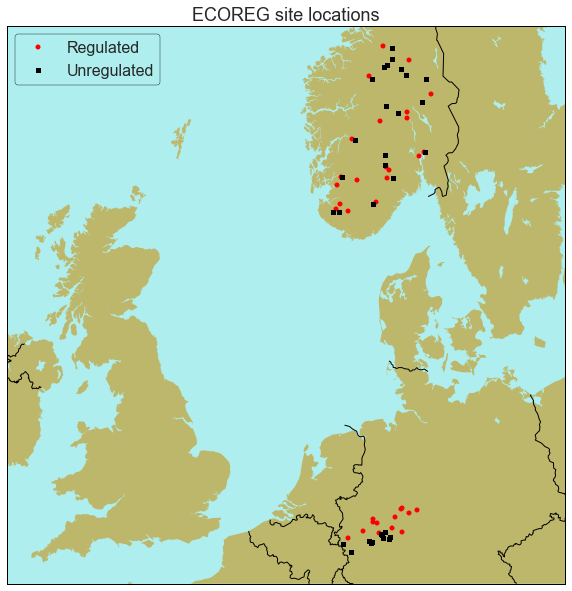

In [3]:
# Map
# Map of sites
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=1500000,
            height=1500000,
            resolution='i',
            lat_1=46.5,          # 1st standard parallel
            lat_2=66.5,          # 2st standard parallel
            lon_0=4,lat_0=56.5)  # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='paleturquoise')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Map (long, lat) to (x, y) for plotting
x, y = m(site_df['lon'].values, site_df['lat'].values)

# Add to df
site_df['east'] = x
site_df['north'] = y

# Get reg and unreg
reg_df = site_df.query('regulated == 1')
ureg_df = site_df.query('regulated == 0')

# Plot
plt.plot(reg_df['east'], reg_df['north'], 'or', markersize=5, label='Regulated')
plt.plot(ureg_df['east'], ureg_df['north'], 'sk', markersize=5, label='Unregulated')
plt.title('ECOREG site locations', fontsize=18)
l = plt.legend(loc='upper left', fontsize=16, 
               frameon=True, fancybox=True)
l.get_frame().set_facecolor('paleturquoise')
l.get_frame().set_edgecolor('k')

In [4]:
# Interactive map - may be useful for exploring site properties?
fig = plt.figure(figsize=(10, 10))
plt.plot(reg_df['lon'], reg_df['lat'], 'or', markersize=15, label='Regulated')
plt.plot(ureg_df['lon'], ureg_df['lat'], 'sk', markersize=15, label='Unregulated')

mplleaflet.display()

### 3.2. Water chemistry and ecology datasets

All 65 sites have been surveyed for PB, and 61 of the 65 have approximately contemporaneous MZB data as well. In Norway, all ecological surveys (for both PB and MZB) took place during September 2013, but the sampling dates in Germany were more variable (**add details?**). For PB, the metrics measured were species **richness** and **abundance**, both for the overall assemblage and subdivided according to red algae, green algae and cyanobacteria. For MZB, a wide variety of metrics were calculated using the [ASTERICS software package](http://www.asterics.de/en/download/berechnung/) (version 4; **reference?**):

 * Abundance [ind/m2]
 * Number of Taxa
 * German Saprobic Index (new version)
 * Average score per Taxon
 * Diversity (Shannon-Wiener-Index)
 * Evenness
 * Grazers and scrapers [%]
 * Miners [%]
 * Xylophagous Taxa [%]
 * Shredders [%]
 * Gatherers/Collectors [%]
 * Active filter feeders [%]
 * Passive filter feeders [%]
 * Predators [%]
 * Parasites [%]
 * Swimming/skating [%]
 * Swimming/diving [%]
 * Burrowing/boring [%]
 * Sprawling/walking [%]
 * (Semi)sessile [%]
 * EPT-Taxa [%]
 * Number of Genera
 * Life Index

The ecological metrics were standardised to adjust for differences in the survey strategies used in Germany and Norway (**more detail needed**).

During each field visit, water samples were collected at each survey location and analysed for total nitrogen (TN), total phosphorus (TP) and total organic carbon (TOC). In-situ measurements of pH and conductivity were also taken using a hand-held probe.

### 3.3. Hydrological data

Sites were selected to be coincident with flow gauging stations, such that daily average flow data are available for all 65 locations. Long discharge datasets are available for some stations, but many of the older datasets have problems with missing data in the early parts of the series. Each site has at least three years' worth of daily flow data spanning the period immediately prior to ecological sampling. 

The raw data series were processed to generate a range of hydrological parameters, closely based on the IHA metrics defined by [Richter et al. (1996)](http://onlinelibrary.wiley.com/doi/10.1046/j.1523-1739.1996.10041163.x/abstract). The IHA software for calculating these metrics was not used, however, as for this study a single set of metrics based on the three year period prior to sampling was desired for each site, rather than splitting the data according to e.g. water or calendar years as implemented by the [IHA R package](https://github.com/jasonelaw/iha). Small gaps in the daily flow series (up to **xxx days in length**) were filled using linear interpolation prior to calculating the metrics. 

For a more detailed description of the metrics used, see [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/hydro_indicators_diy.ipynb). **NB:** I probably need to revisit these based my earlier work, as I've already found essentially no relationship between these HIs and the ecology. **Spend some time identifying additional metrics that might be (i) relevant and (ii) fairly easy to calculate**.

## 4. Statistical analysis

(This section will eventually need separating into "Methods" and "Results", but for now it's easier to treat them together).

### 4.1. Dimensionality reduction

We have a large number of ecological metrics (both for PB and MZB), together with a wide range of possible explanatory parameters (30+ HIs and 5 chemistry variables). The number of possible relationships to test is therefore unfeasibly large, and must be narrowed down using a combination of **domain knowledge** and techniques for **dimensionality reduction**. Furthermore, because many of the variables are similar in nature and meaning (e.g. there are several diversity-based ecological indices), it seems very likely that **collinearity** will be a problem for any statistical tests.

In the following analysis I will follow the recommendations of [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) and [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321) by using PCA to identify a subset of the original variables for further analysis. [Olden & Poff (2003)](http://onlinelibrary.wiley.com/doi/10.1002/rra.700/abstract) suggest that a pragmatic approach is to choose the indicator with the highest loading in each of the first few PCs: 

> *Such an approach may be particularly useful in large-scale, data-intensive studies where indices other than hydrologic indices are being examined and related to patterns in biological data*. 

Note that PCA is srongly affected by outliers, so it's a good idea to screen for possible data issues before calculating the PCs.

I've started off by defining a convenience function for the PCA, which I've shifted into a separate Python file in order to keep this notebook tidy. The full code can be found [here](https://github.com/JamesSample/ECOREG/blob/master/ecoreg_code.py). The code below imports this for use in this notebook.

In [5]:
# Import custom functions
func_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Python\ECOREG\ecoreg_code.py'

ecoreg = imp.load_source('ecoreg_code', func_path)

#### 4.1.1. PB data

Previous work in section 2.2 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis.ipynb) compared PB distributions in Norway and Germany. In general, the patterns for abundance and richness are very similar: the species richness and abundance of green algae and cyanobacteria in Norway are greater than in Germany, whereas the abundance and richness of red algae is broadly similar in both locations. As a result, overall richness and abundance is also greater in Norway than in Germany. 

The "overall" scores therefore do a reasonable job of representing the main patterns in the underlying green algae and cyanobacteria data. With this in mind, it seems reasonable to represent the PB data using (i) one of the overall scores and (ii) one of the red algage metrics. The abundance scores were originally evaluated on a qualitative scale, which perhaps makes them less reliable than the richness scores (?). For this reason, I'm tempted to use **overall PB richness** and **red algae richness** as the two primary indicators of PB response in this analysis. Let's see if this looks reasonable based on PCA.

Variance explained by first 3 PCs (%):

[ 65.73055143  19.87475925   8.66550247]

Total: 94.27%


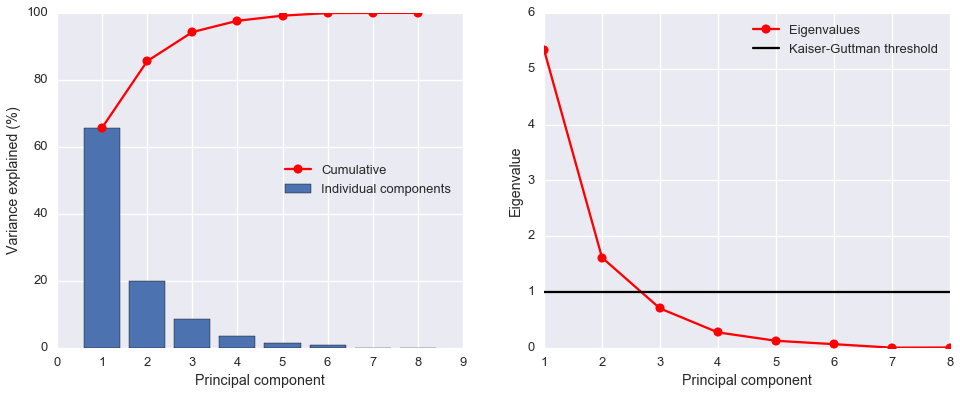

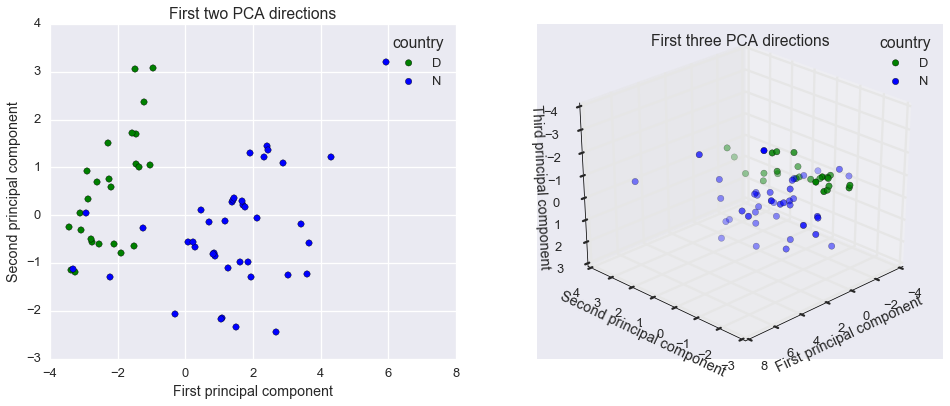

,1,2,3,4,5,6,7,8
pb_rich,0.428859,-0.041165,0.087100,-0.075465,0.415437,-0.151304,-0.445185,-0.638305
green_rich,0.393252,-0.178867,0.391503,-0.035225,0.328727,-0.502096,0.310347,0.449853
cyano_rich,0.384301,0.016484,-0.507064,0.000820,0.468649,0.533672,0.160601,0.254355
red_rich,0.177480,0.660157,0.061499,-0.711345,-0.133826,-0.010413,0.032546,0.061831
pb_abund,0.427192,-0.058692,0.089513,0.144335,-0.416324,0.132271,-0.639942,0.429965
green_abund,0.388885,-0.178258,0.425099,0.020433,-0.351897,0.456703,0.447605,-0.321101
cyano_abund,0.360644,-0.099113,-0.617909,0.027442,-0.427967,-0.456083,0.236623,-0.174325
red_abund,0.135859,0.696555,0.087804,0.681945,0.038676,-0.077509,0.113033,-0.057575


In [6]:
# Join categorical variables to PB data
df = pb_df.join(site_df['country'])

# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_rich', 'red_rich', 
           'pb_abund', 'green_abund', 'cyano_abund', 'red_abund']

# Run PCA
res = ecoreg.run_pca(df, cols=pb_cols, c='country')
res

The (very approximate/dodgy) Kaiser-Guttman criterion (KGC) implies keeping the first two PCs, which together explain (66 + 20) = 86% of the total variance. In these two dimensions, there is a fairly clear (essentially linear) separation between the points from Norway and those from Germany (bottom-left plot above). Note that repeating the same analysis using `Is regulated?` for the colours does not show a clear pattern, which immediately suggests that we will have difficulty detecting differences between regulated and unregulated sites based on PB assemblages alone (see section 1 hypothesis 1).

The loadings in the table above are also interesting. PC1 is dominated by overall richness and abundance, but with significant contributions from the green algae and cyanobacteria metrics. PC2 is overwhelmingly dominated by the metrics for red algae, and the loadings for the other PCs are more difficult to interpret. In a similar study by [Gao et al. (2009)](http://www.sciencedirect.com/science/article/pii/S0022169409003321), the authors used the KGC to determine the number of PCs to keep, and they performed dimensionality reduction by choosing the metric with the largest loading for each of these PCs. Applying this approach here leads to the selection PB richness to represent PC1 and red algae abundance to represent PC2. However, the difference in loadings between red algae abundance and red algae richness on PC2 is small (0.70 versus 0.66, respectively), and because I have greater faith in the quality of the richness data **I'm going to choose overall PB richness and red algae richness as the two metrics to represent PB variability**. 

#### 4.1.2. MZB data

The MZB dataset is rather more complicated than the PB data, with many more possible variables to consider. The various indicators (listed in section 3.2 above) can be divided into three broad categories: metrics describing mode of life (swimming, burrowing etc.); metrics describing feeding behaviour (miners, filter feeders etc.); and "overall" ecological summaries such as the LIFE Index or the Shannon-Wiener Diversity. In general, my preference is to include the overall metrics if possible, rather than focusing on just a small set of behaviours or modes of life. Previous exploratory analysis (section 2.1 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis.ipynb)) compared differences between the scores for Germany and Norway. Key patterns identified included:

 * Norway has very few burrowing/boring taxa, whereas these are present at many of the German sites. <br><br>
 
 * German sites generally have few parasites or miners, whereas the Norwegian sites are more variable. <br><br>
 
 * Shredders and xylophages are quite rare in Norway, but do occur in Germany. <br><br>
 
 * When it comes to filter-feeding, German streams are dominated by passive taxa, whereas the opposite is true in Norway. <br><br>

 * There is a strong positive correlation between miners and active filter feeders, but the relationship does not extend to passive filter feeders. Miners are also strongly correlated with parasites, perhaps because some miners are parasites? <br><br>
 
 * There is a positive relationship between parasites and active filter-feeders, suggesting that active filter feeders are commonly parasitised? <br><br>
 
 * Most German and Norwegian sites have similar overall abundance, but the histogram for Norway is strongly skewed, indicating that a few of the Norwegian sites have very high abundances indeed. <br><br>
 
 * German sites tend to have a larger number of taxa and genera i.e. more diversity (and also greater "evenness", whatever that means). Both countries have very similar distributions of EPT taxa, but the LIFE index for the Norwegian streams is much more variable than for the sites in Germany, albeit with approximately the same overall mean.


Variance explained by first 3 PCs (%):

[ 38.21207649  27.21782787  12.15311027]

Total: 77.58%


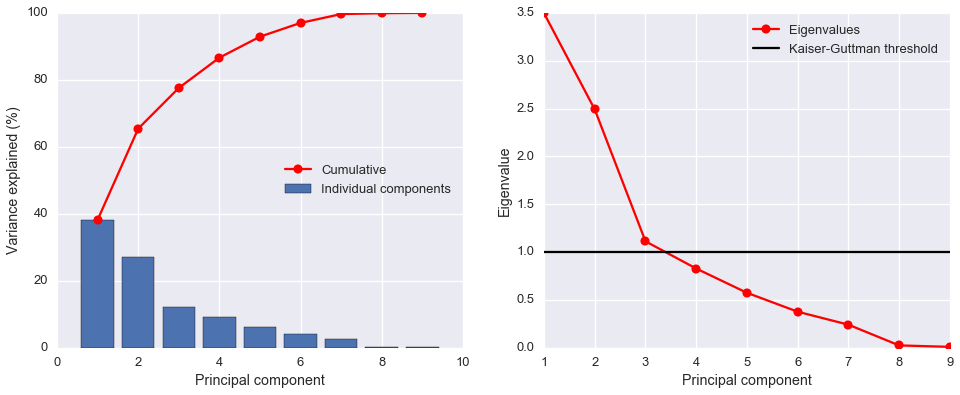

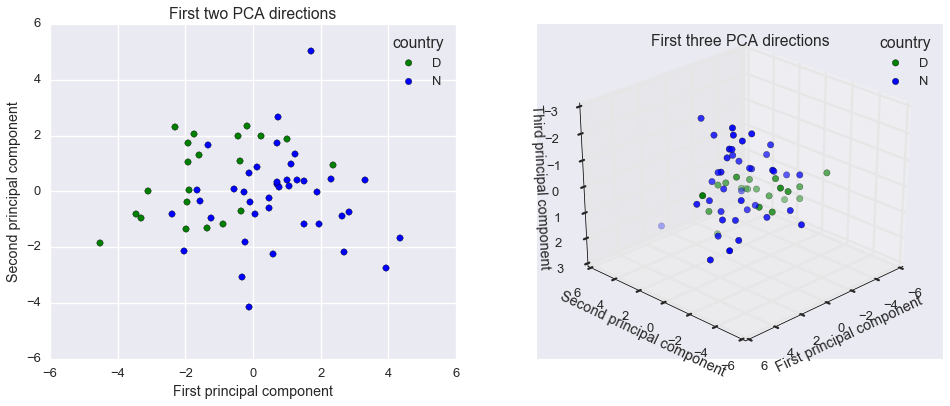

av_score_p_taxon   -0.260891
even               -0.037521
shan_wei_idx        0.014624
abund               0.049873
n_genera            0.091513
n_taxa              0.151119
ept_taxa            0.426907
life_idx            0.440415
ger_sap_idx         0.721388
Name: 3, dtype: float64

In [16]:
# Join categorical variables to MZB data
df = mzb_df.join(site_df['country'])

# Columns to consider
mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'graz_scrap', 'miners', 'xylo',
            'shred', 'gath_coll', 'acti_filt_feed', 'pass_filt_feed',
            'pred', 'para', 'swim_skat', 'swim_div', 'burr_bore', 
            'sprawl_walk', 'sessil', 'ept_taxa', 'n_genera', 'life_idx']

mzb_cols = ['abund', 'n_taxa', 'ger_sap_idx', 'av_score_p_taxon', 
            'shan_wei_idx', 'even', 'ept_taxa', 'n_genera', 'life_idx']

# Run PCA
res = ecoreg.run_pca(df, cols=mzb_cols, c='country')
res[3].sort_values()

=> Shannon-Wiener for PC1, Av. score per taxon for PC2 and German saprobic Index for PC3. Including all other vars is a bit of a mess.